In [62]:
import pandas as pd
import datetime
from math import ceil
import matplotlib.pyplot as plt
import torch
import numpy as np
from importlib import reload
import random
from random import shuffle

import rl4pm_lib.preprocessing as preprocessing
reload(preprocessing)
from IPython import display

In [63]:
test_df = pd.read_csv('datasets/test_df.csv').drop(columns='Unnamed: 0')
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: datetime.datetime.fromisoformat(x))

train_df = pd.read_csv('datasets/train_df.csv').drop(columns='Unnamed: 0')
train_df['timestamp'] = train_df['timestamp'].apply(lambda x: datetime.datetime.fromisoformat(x))

### Propro like for SklEarn

In [64]:
import rl4pm_lib.preprocessing as preprocessing

column_feature = {'tt': 0, 'te': 1, 'tw': 2}
prepro = preprocessing.DfPreprocesser()
prepro.fit(train_df)
train_df_pr = prepro.transform(train_df)
test_df_pr = prepro.transform(test_df)

In [65]:
scaler = preprocessing.PaperScaler(column_feature)
scaler.fit(train_df_pr)
train_df_pr_sc = scaler.transform(train_df_pr)
test_df_pr_sc = scaler.transform(test_df_pr)

In [66]:
window_size = 2

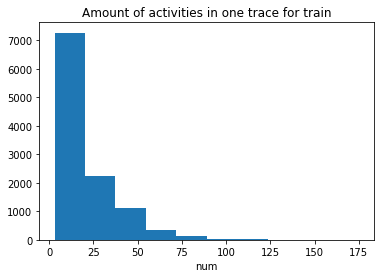

In [67]:
traces_train = list(set(train_df_pr_sc['trace_id'].values))
traces_train_len = {}
for t in traces_train:
    trace_len = train_df_pr_sc[train_df_pr_sc['trace_id'] == t].shape[0]
    if trace_len > window_size:
        traces_train_len[t] = trace_len
traces_train = list(traces_train_len.keys())

plt.hist(list(traces_train_len.values()))
plt.title('Amount of activities in one trace for train')
plt.xlabel('Trace len')
plt.xlabel('num')
plt.show()

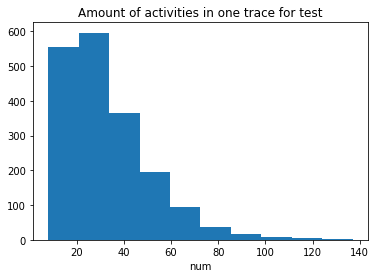

In [68]:
traces_test = list(set(test_df_pr_sc['trace_id'].values))
traces_test_len = {}
for t in traces_test:
    trace_len = test_df_pr_sc[test_df_pr_sc['trace_id'] == t].shape[0]
    if trace_len > window_size:
        traces_test_len[t] = trace_len
traces_test = list(traces_test_len.keys())

plt.hist(list(traces_test_len.values()))
plt.title('Amount of activities in one trace for test')
plt.xlabel('Trace len')
plt.xlabel('num')
plt.show()

## Ok let's create data loader & dataset

In [69]:
from rl4pm_lib.lstm_supervised import ProcessesDataset

In [70]:
win_len = 2
test_ds = ProcessesDataset(test_df_pr_sc, win_len)
train_ds = ProcessesDataset(train_df_pr_sc, win_len)

In [71]:
test_ds[0]['data'].shape

torch.Size([137, 54])

In [72]:
test_ds.df_win.columns

Index(['tt', 'te', 'tw', 'trace_id', 'A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED',
       'A_CANCELLED', 'A_DECLINED', 'A_FINALIZED', 'A_PARTLYSUBMITTED',
       'A_PREACCEPTED', 'A_REGISTERED', 'A_SUBMITTED', 'O_ACCEPTED',
       'O_CANCELLED', 'O_CREATED', 'O_DECLINED', 'O_SELECTED', 'O_SENT',
       'O_SENT_BACK', 'W_Afhandelen leads', 'W_Beoordelen fraude',
       'W_Completeren aanvraag', 'W_Nabellen incomplete dossiers',
       'W_Nabellen offertes', 'W_Valideren aanvraag',
       'W_Wijzigen contractgegevens', 'tt__1', 'te__1', 'tw__1',
       'A_ACCEPTED__1', 'A_ACTIVATED__1', 'A_APPROVED__1', 'A_CANCELLED__1',
       'A_DECLINED__1', 'A_FINALIZED__1', 'A_PARTLYSUBMITTED__1',
       'A_PREACCEPTED__1', 'A_REGISTERED__1', 'A_SUBMITTED__1',
       'O_ACCEPTED__1', 'O_CANCELLED__1', 'O_CREATED__1', 'O_DECLINED__1',
       'O_SELECTED__1', 'O_SENT__1', 'O_SENT_BACK__1', 'W_Afhandelen leads__1',
       'W_Beoordelen fraude__1', 'W_Completeren aanvraag__1',
       'W_Nabellen incomplete

In [73]:
from torch.utils.data import DataLoader

batch_size = 256

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


### Modles init

In [75]:
class Net(torch.nn.Module):
    """
    Net used for agents, lstm-based
    Args:
        input_size(int): nuber of features for input
        hidden_layer(int): size of hidden layer
        n_lstm(int): number of lstm stacked for NN
        out_shape(int): out dimension

    Attributes:
        lstm(torch.nn.LSTM): lstm-based piece of nn
        relu(torch.nn.ReLU): activation function
        fc(torch.nn.Linear): fully connected layer
    """
    def __init__(self, input_size, hidden_layer, n_lstm, out_shape):
        super(Net, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_layer,
                                  num_layers=n_lstm)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_layer, out_shape)
        self.out_shape = out_shape
        self.n_lstm = n_lstm
        self.hidden = hidden_layer

    def forward(self, x):
        x, h = self.lstm(x)
        x = self.relu(x)
        x = self.fc(x)
        return x, h

In [82]:
input_size = test_ds.tensor_data.shape[-1]
n_lstm = 3
hidden_layer = 128
n_classes = len(set(train_df['activity'].values))

te_model = Net(input_size=input_size, hidden_layer=hidden_layer, n_lstm=n_lstm,
               out_shape=1).to(device)
ac_model = Net(input_size=input_size, hidden_layer=hidden_layer, n_lstm=n_lstm,
               out_shape=n_classes).to(device)

### Optimizers and losses

In [83]:
loss_ac = torch.nn.CrossEntropyLoss()
optimizer_ac = torch.optim.Adam(ac_model.parameters(), lr=1e-3)

loss_te = torch.nn.SmoothL1Loss()
optimizer_te = torch.optim.Adam(ac_model.parameters(), lr=1e-3)

In [85]:
loss = torch.nn.CrossEntropyLoss()
input_ = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input_, target)
output.backward()

In [89]:
def train(dataloader, device,
          model_ac, loss_ac, optimizer_ac,
          model_te, loss_te, optimizer_te,
          scaler):
    size = len(dataloader.dataset)
    n = 0
    true = 0
    mae_error = 0
    
    for batch, data_dict in enumerate(train_dataloader):
        
        x = data_dict['data'].to(device)
        _bs = x.shape[0] # define btch size (it can be not as defined for residula piece of data)
        x = x.transpose(0,1).view(-1, _bs, input_size)

        is_done = data_dict['is_done']
        is_done = is_done.transpose(0,1).view(-1, _bs, 1)

        true_label = data_dict['label'].to(device)
        true_label = true_label.transpose(0,1).view(-1, _bs, 1)

        true_tes = data_dict['tes'].to(device)
        true_tes = true_tes.transpose(0,1).view(-1, _bs, 1)

        pred_label, _ = ac_model(x)
        pred_label = torch.nn.functional.softmax(pred_label, dim=-1)

        pred_te, _ = te_model(x)
        pred_te = torch.nn.functional.relu(pred_te)

        # whanna drop useless padded -1, which are stored in is_done
        is_done = is_done.reshape(-1).bool()
        true_label = true_label.reshape(-1)[is_done]
        pred_label = pred_label.reshape((-1, n_classes))[is_done]

        pred_te = pred_te.reshape(-1)[is_done]
        true_tes = true_tes.reshape(-1)[is_done]

        # ok let's calc losses

        loss_ac_ = loss_ac(pred_label, true_label.long())
        optimizer_ac.zero_grad()
        loss_ac_.backward()
        optimizer_ac.step()

        loss_te_ = loss_te(pred_te, true_tes)
        optimizer_te.zero_grad()
        loss_te_.backward()
        optimizer_te.step()
        
        n += is_done.sum()
        true += (pred_label.argmax(1) == true_label.long()).type(torch.float).sum().item()
        mae_error += torch.abs(pred_te - true_tes).sum().item()

#         if batch % 100 == 0:
#             print(f'loss ac = {loss_ac_.item():.2}\nloss te = {loss_te_.item():.2},')
            
#             print(f'batch:[{batch:>5d}/{size:>5d}]')
    mae = mae_error*scaler.scales["te"] / n / 60 / 60 / 24
    acc = true / n
    print('____'*15)
    print(f'MAE     ={mae_error*scaler.scales["te"] / n / 60 / 60 / 24 : .2f} days')
    print(f'Accuracy={true / n: .2f}')
    
    return {'MAE': mae, 'Accuracy': acc}

In [90]:
for ep in range(60):
    print(f'epoch {ep}')
    train(dataloader=train_dataloader,
          device=device,
          model_ac=ac_model, loss_ac=loss_ac,
          model_te=te_model, loss_te=loss_te,
          optimizer_ac=optimizer_ac, optimizer_te=optimizer_te,
         scaler=scaler)

epoch 0
____________________________________________________________
MAE     = 4.10 days
Accuracy= 0.35
epoch 1
____________________________________________________________
MAE     = 4.10 days
Accuracy= 0.36
epoch 2
____________________________________________________________
MAE     = 4.10 days
Accuracy= 0.40
epoch 3
____________________________________________________________
MAE     = 4.10 days
Accuracy= 0.46
epoch 4
____________________________________________________________
MAE     = 4.10 days
Accuracy= 0.49
epoch 5
____________________________________________________________
MAE     = 4.10 days
Accuracy= 0.49
epoch 6
____________________________________________________________
MAE     = 4.10 days
Accuracy= 0.49
epoch 7
____________________________________________________________
MAE     = 4.10 days
Accuracy= 0.49
epoch 8
____________________________________________________________
MAE     = 4.10 days
Accuracy= 0.48
epoch 9
________________________________________________________